## 1. Loading the data set.

In [1]:
import torch

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# Loading the Dataset Fashion-MNIST
MNIST_train_data = datasets.FashionMNIST(
    root='data', train=True, 
    transform=ToTensor(), download=True,)
MNIST_test_data = datasets.FashionMNIST(
    root='data', train=False, transform=ToTensor())

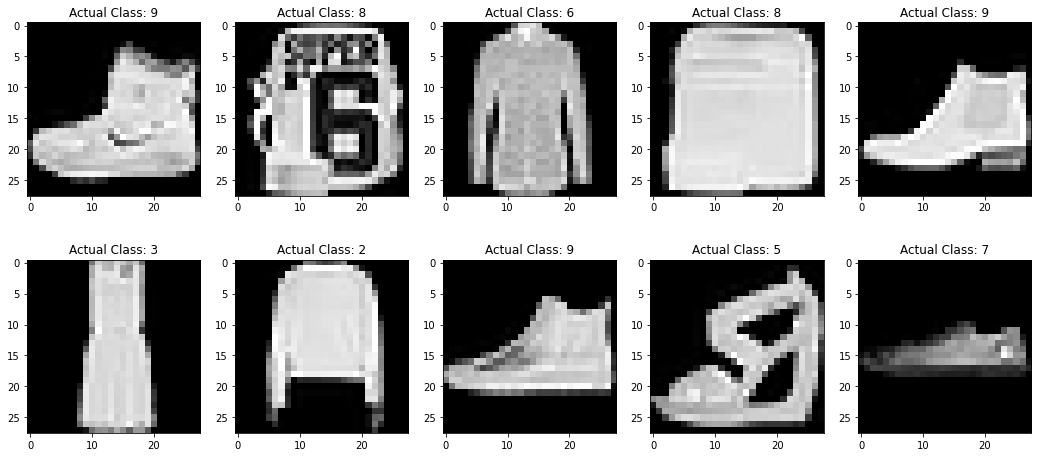

In [3]:
import math
import cv2
from matplotlib import pyplot as plt

display_num_of_images = 10
display_per_row = 5
rows, cols = math.ceil(display_num_of_images/display_per_row), display_per_row
row, col = 0, 0
f, ax_arr = plt.subplots(rows, cols, figsize=(18, 8))
train_data_len = len(MNIST_train_data.data)
for i in range(train_data_len):
    if i % (train_data_len/display_num_of_images) == 0:
        sub_ax = ax_arr[row, col]
        sub_ax.imshow(MNIST_train_data.data[i], cmap='gray')
        sub_ax.set_title(f'Actual Class: {MNIST_train_data.targets[i]}')
        col += 1
        if (col == display_per_row):
          col, row = 0, (row + 1)
        
plt.show()

## 2. Create the Train and Validation Datasets and Preprocessing the images.

In [4]:
train_data_len = len(MNIST_train_data)
train_data, valid_data = torch.utils.data.random_split(
        MNIST_train_data, 
        [int(train_data_len*0.9), int(train_data_len*0.1)], 
        generator=torch.Generator().manual_seed(1351))

In [5]:
from torch.utils.data import DataLoader
import torch.nn.functional as F

batch_size = 32
loaders = {
    'train': torch.utils.data.DataLoader(
        train_data.dataset, batch_size=batch_size, 
        shuffle=True, num_workers=2),
    'validation': torch.utils.data.DataLoader(
        valid_data.dataset, batch_size=batch_size, 
        shuffle=True, num_workers=2),    
    'test': torch.utils.data.DataLoader(
        MNIST_test_data, batch_size=batch_size, 
        shuffle=True, num_workers=2),
}

## 3. Implementing CNNs using PyTorch.

In [6]:
from torch import nn
class MNIST_CNN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1,4,kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(4, eps=1e-5, momentum=0.1,
                           affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, 
                         dilation=1, ceil_mode=False),

            nn.Conv2d(4,4,kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(4, eps=1e-5, momentum=0.1,
                           affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, 
                         dilation=1, ceil_mode=False)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=196, out_features=10, bias=True)
        )
        
    def forward(self, X):
        X = self.cnn_layers(X)
        X = X.view(X.size(0), -1)
        X = self.linear_layers(X)
        
        return F.log_softmax(X, dim = 1)

In [7]:
model = MNIST_CNN_Net().to(device)
print(model)

MNIST_CNN_Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [8]:
from torch.optim import Adam
import statistics

def train_model_classifier(train_loader, 
                           validation_loader, 
                           NNModelClassifier, 
                           epochs=25):
    loss_function = nn.CrossEntropyLoss()
    optimization_algorithm = Adam(NNModelClassifier.parameters(), lr=0.01)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        batch_train_loss = []
        for train_X, train_y in train_loader:
            optimization_algorithm.zero_grad()
            output = NNModelClassifier(train_X.to(device))
            loss = loss_function(output, train_y.to(device))
            loss.backward()
            optimization_algorithm.step()
            batch_train_loss.append(loss.item())
        epoch_train_loss = statistics.mean(batch_train_loss)
        training_loss.append(epoch_train_loss)  

        with torch.no_grad():
            batch_valid_loss = []
            for validation_X, validation_y in validation_loader:
                output = NNModelClassifier(validation_X.to(device))
                loss = loss_function(output, validation_y.to(device))
                batch_valid_loss.append(loss.item())
            epoch_valid_loss = statistics.mean(batch_valid_loss)
            validation_loss.append(epoch_valid_loss)
            print(f'Epoch {epoch:2d} - Validation Loss: {loss}')
    return NNModelClassifier, training_loss, validation_loss

In [9]:
ret = train_model_classifier(
    loaders['train'], loaders['validation'], 
    model, 
    # epochs=2,
    )

trained_classifier_model, training_loss, validation_loss = ret

Epoch  0 - Validation Loss: 0.42577797174453735
Epoch  1 - Validation Loss: 0.1469193547964096
Epoch  2 - Validation Loss: 0.1770656853914261
Epoch  3 - Validation Loss: 0.3261999487876892
Epoch  4 - Validation Loss: 0.21770282089710236
Epoch  5 - Validation Loss: 0.16733214259147644
Epoch  6 - Validation Loss: 0.2576429545879364
Epoch  7 - Validation Loss: 0.37308675050735474
Epoch  8 - Validation Loss: 0.25186464190483093
Epoch  9 - Validation Loss: 0.27562230825424194
Epoch 10 - Validation Loss: 0.23923125863075256
Epoch 11 - Validation Loss: 0.17017319798469543
Epoch 12 - Validation Loss: 0.31967249512672424
Epoch 13 - Validation Loss: 0.49689075350761414
Epoch 14 - Validation Loss: 0.3342779278755188
Epoch 15 - Validation Loss: 0.07857142388820648
Epoch 16 - Validation Loss: 0.0837089940905571
Epoch 17 - Validation Loss: 0.5171058177947998
Epoch 18 - Validation Loss: 0.4808836877346039
Epoch 19 - Validation Loss: 0.4109492897987366
Epoch 20 - Validation Loss: 0.19586724042892456
E

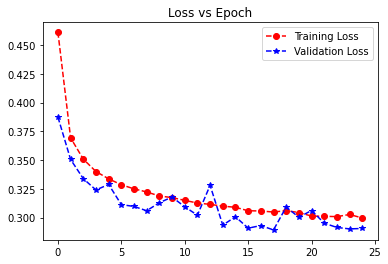

In [10]:
plt.plot(training_loss, label='Training Loss', 
         marker='o', linestyle='--', color='r')
plt.plot(validation_loss, label='Validation Loss', 
         marker='*', linestyle='--', color='b')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [11]:

def get_accuracy(total_data_len, data_loader):
    correct_count = 0
    with torch.no_grad():
        for X, y in data_loader:
            output = trained_classifier_model(X.to(device))
            output = torch.max(output, 1)[1]
            correct_count += (output == y.to(device)).float().sum()
        accuracy = (correct_count.item()/total_data_len) * 100
    return accuracy


train_data_acc = get_accuracy(
    len(train_data.dataset.data), 
    loaders['train'])
print("Training   Dataset ==> Accuracy:", train_data_acc)

valid_data_acc = get_accuracy(
    len(valid_data.dataset.data), 
    loaders['validation'])
print("Validation Dataset ==> Accuracy:", valid_data_acc)


Training   Dataset ==> Accuracy: 89.50666666666666
Validation Dataset ==> Accuracy: 89.47166666666668


## 4. Generating predictions for the test set.

4 8

batchId: 0


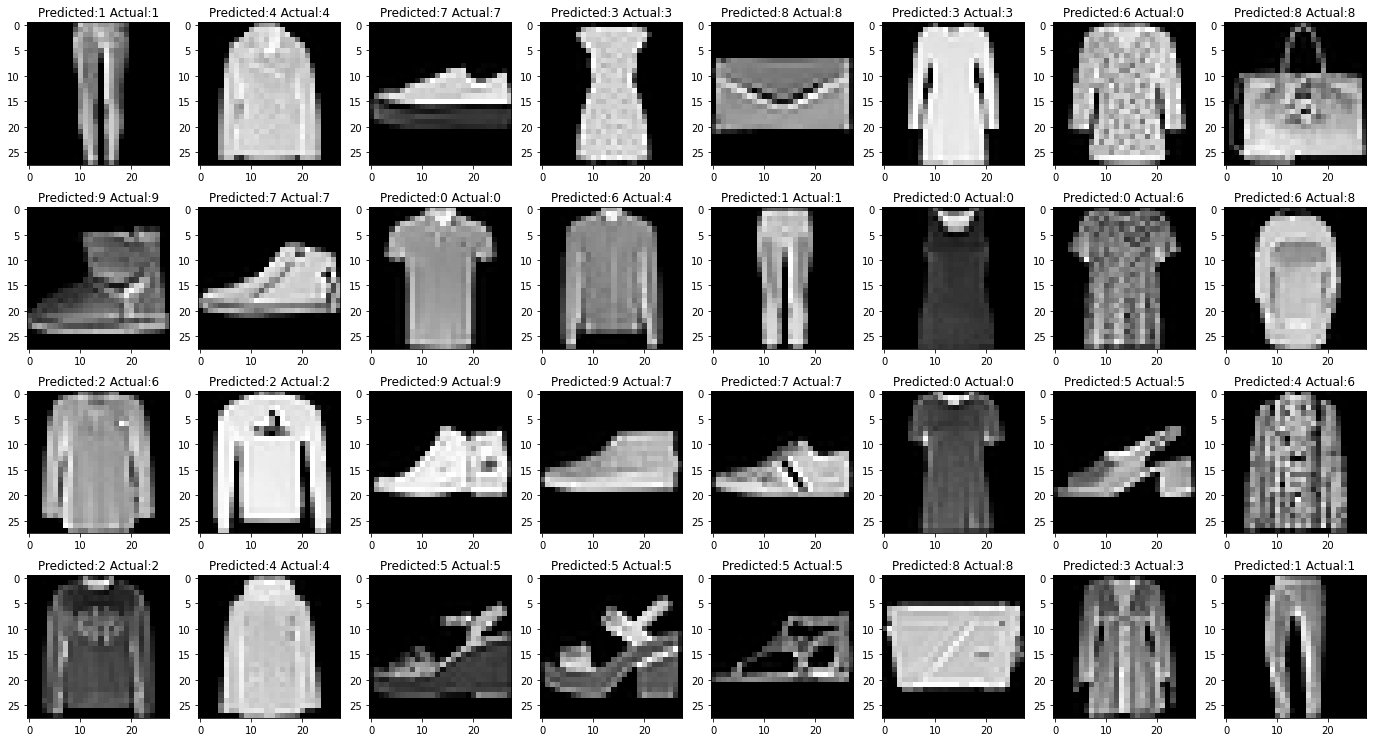


batchId: 100


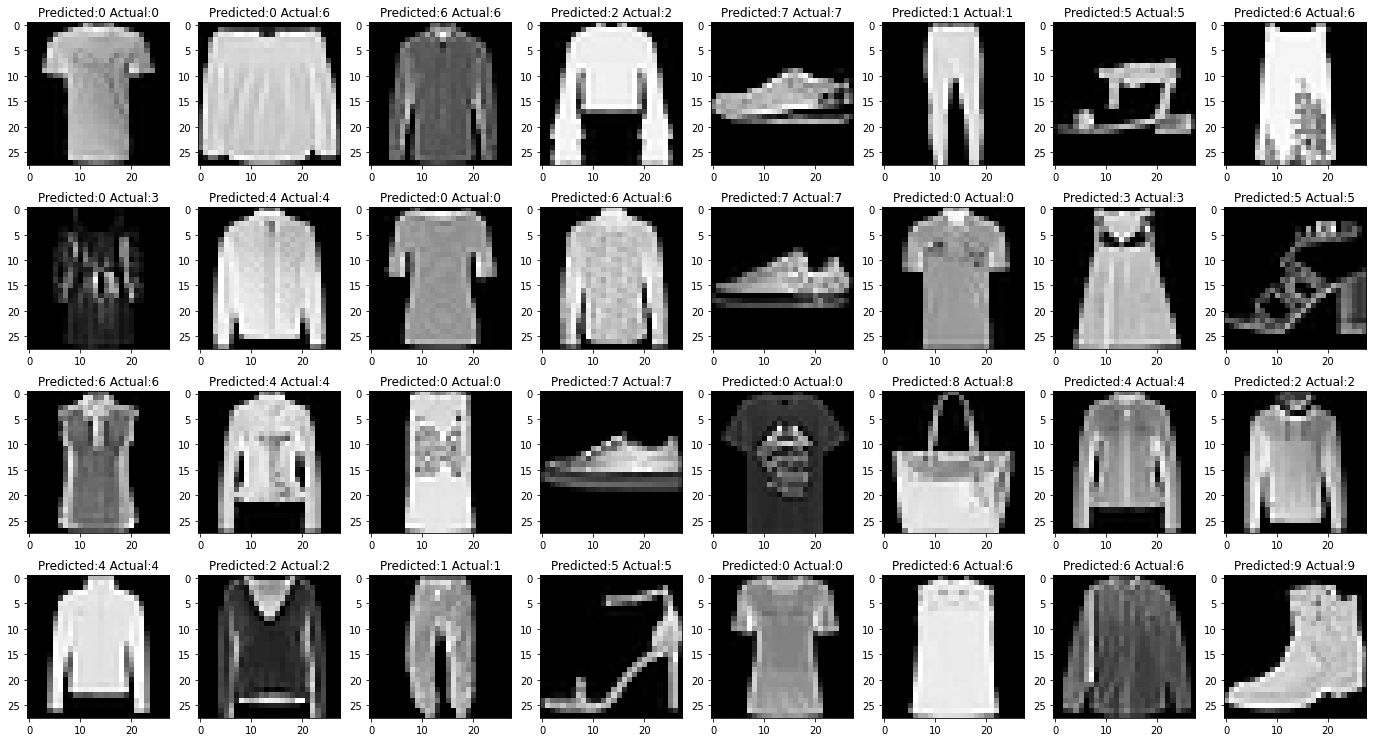


batchId: 200


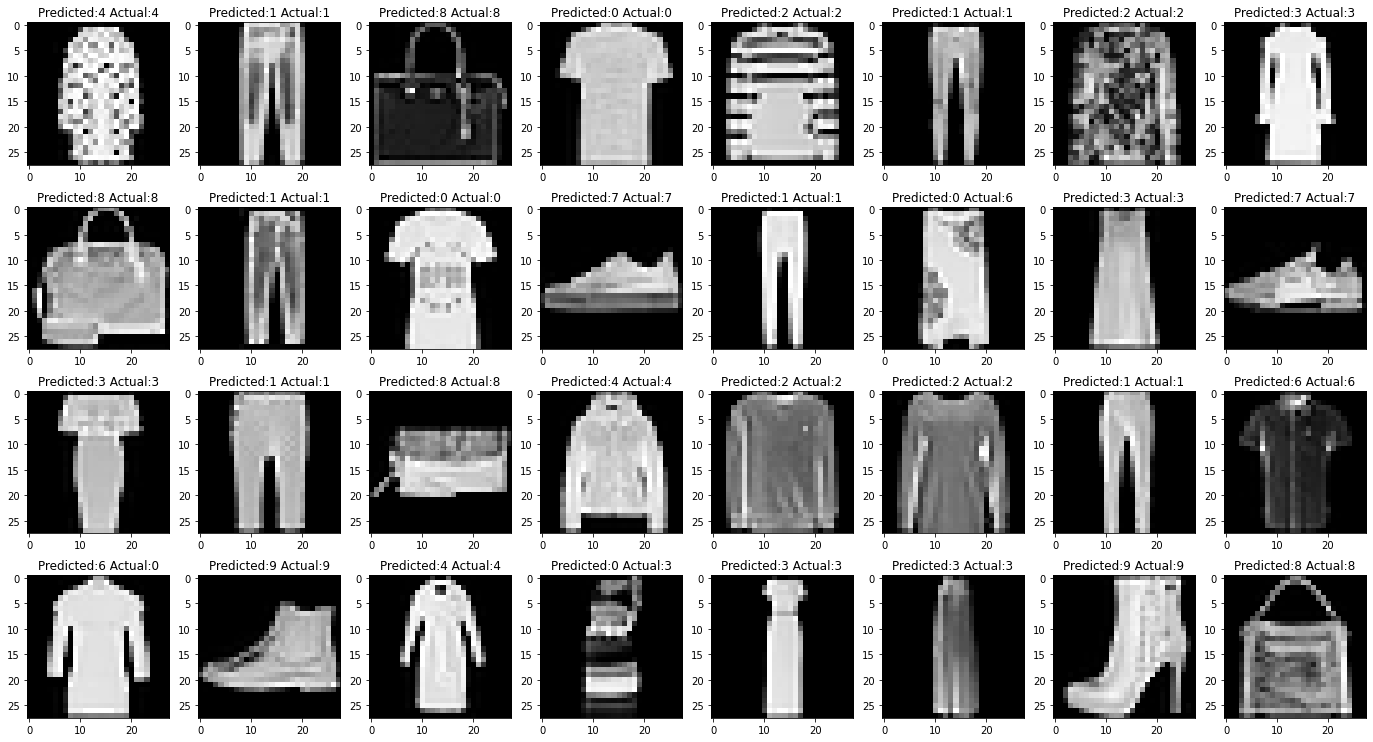


batchId: 300


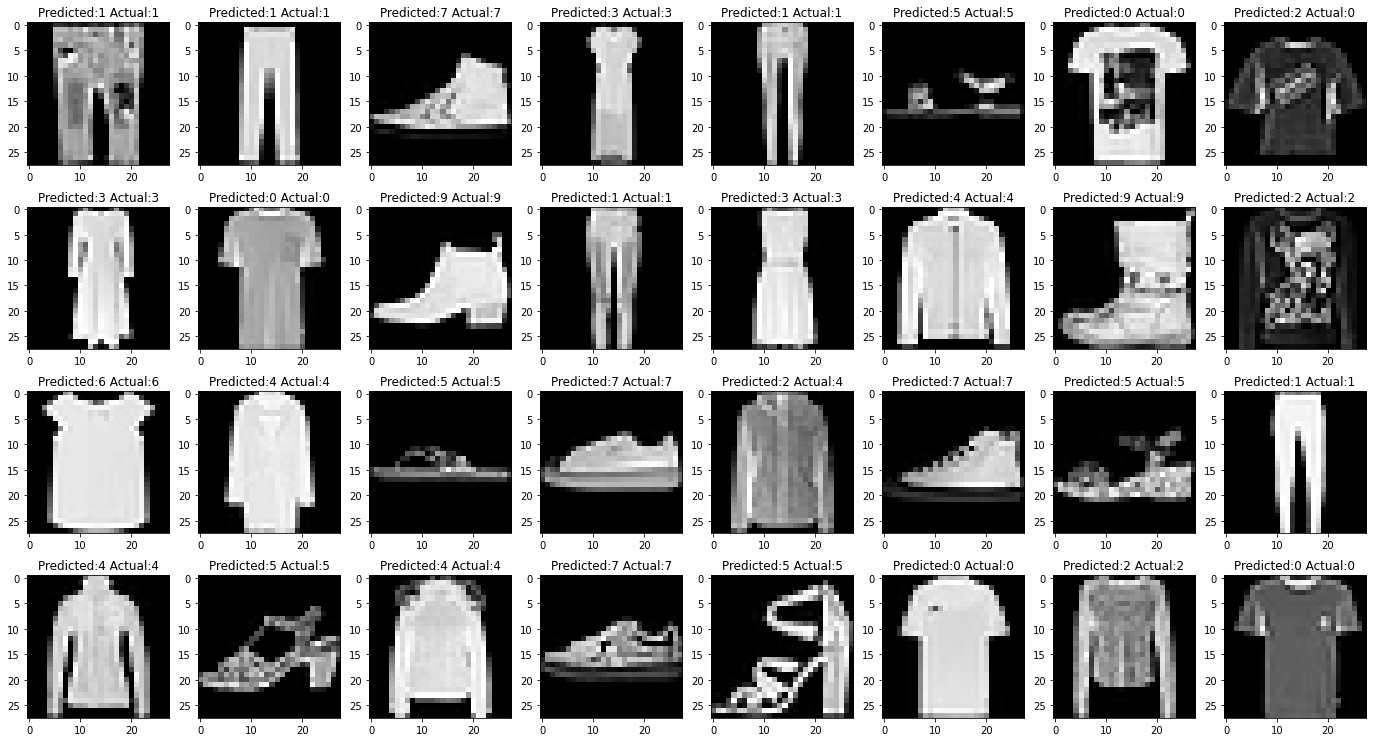

In [12]:
import math

# Plot Generated Predictions on Test Images
display_num_of_images = batch_size  # batch_size=32
display_per_row = 8
rows, cols = math.ceil(display_num_of_images/display_per_row), display_per_row
print(rows, cols)

def plot_batch(batchId, X, y_true, y_pred):
    row, col = 0, 0
    f, ax_arr = plt.subplots(rows, cols, figsize=(24, 13))
    print(f"\nbatchId: {batchId}")
    for idx in range(len(batch_X)):
        sub_ax = ax_arr[row, col]
        sub_ax.imshow(X[idx][0], cmap='gray')
        sub_ax.set_title(f'Predicted:{y_pred[idx]} Actual:{y_true[idx]}')
        col += 1
        if (col == display_per_row):
          col, row = 0, (row + 1)
    plt.show()

with torch.no_grad():
    batch = 0
    for batch_X, batch_y in loaders['test']:
        pred = trained_classifier_model(batch_X.to(device))
        pred = torch.max(pred, 1)[1]
        if (batch % 100 == 0):
            plot_batch(batch, batch_X, batch_y, pred)
        batch += 1